# A Predictive Analysis of Restaurant Reviews through Text-Based Classification Modeling
#### ADS 509 Final Project | Team 3 | Saba Alemayehu, John Chen, and Anusia Edward

In [174]:
# Necessary Imports 
import requests
import pandas as pd
import numpy as np
import json
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

from collections import Counter
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

## Part 1: Data Acquisition through Web Scraping 

In [27]:
# Function to Scrape Yelp Reviews
webdriver_john = '/Users/JohnnyBlaze/drivers/chromedriver'
webdriver_anusia = '/Users/anusiaedward/Downloads/chromedriver_mac_arm64/chromedriver'
#webdriver_saba = ''

def scrape_yelp_pages(url):
    # Set up Chrome driver service
    service = webdriver.chrome.service.Service(webdriver_anusia)  
    service.start()

    # Set up Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  

    # Create a new instance of the Chrome driver
    driver = webdriver.Chrome(service=service, options=options)

    # Navigate to the webpage
    driver.get(url)

    # Wait for the page to load and for the first page number element to be visible
    page_number_element = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.XPATH, '//div[@aria-label="Page: 1"]'))
    )

    reviews = []
    star_ratings = []
    dates = []

    while True:
        # Process the current page here
        review_elements = driver.find_elements(By.XPATH, '//span[@class=" raw__09f24__T4Ezm" and @lang="en"]')
        star_rating_elements = driver.find_elements(By.XPATH, '//div[contains(@aria-label, "star rating")]')
        date_elements = driver.find_elements(By.XPATH, '//span[@class=" css-chan6m"]')

        for review_element, star_rating_element, date_element in zip(review_elements, star_rating_elements, 
                                                                     date_elements):
            review_text = review_element.text
            star_rating = star_rating_element.get_attribute('aria-label')
            date = date_element.text

            # Ignore dates with the words 'Photos', 'years', 'Photo', and 'year'
            if 'Photos' not in date and 'years' not in date and 'Photo' not in date and 'year' not in date:
                reviews.append(review_text)
                star_ratings.append(star_rating)
                dates.append(date)

        try:
            # Click on the next page
            next_page_arrow = driver.find_element(By.XPATH, '//span[@class="icon--24-chevron-right-v2\
            navigation-button-icon__09f24__Bmrde css-1kq79li"]')
            next_page_arrow.click()

            # Wait for a brief moment for the new review elements to load
            WebDriverWait(driver, 1).until(EC.presence_of_element_located((By.XPATH, '//span[@class="\
            raw__09f24__T4Ezm" and @lang="en"]')))

        except:
            # Break the loop when there are no more pages to click
            break

    # Close the browser window
    driver.quit()

    # Create a DataFrame with the scraped data
    data = pd.DataFrame({'Date': dates, 'Review': reviews, 'Star Rating': star_ratings})

    return data

In [28]:
# Filippi's Pizza

pizza_df = scrape_yelp_pages('https://www.yelp.com/biz/filippis-pizza-grotto-mission-valley-san-diego?osq=pizza')

pizza_df.head()

,Date,Review,Star Rating
0,1/19/2023,You've never had a good pizza till you've had ...,1 star rating
1,1/18/2023,"This is my Kids FAV pizza in town. Yes, it may...",5 star rating
2,12/4/2022,I ordered a basil and cheese pizza and it is p...,5 star rating
3,8/26/2016,"Myself, and my dear Friend and her daughter vi...",4 star rating
4,2/13/2015,Me and my co-workers went to this location for...,5 star rating


In [ ]:
# To CSV

csv_file_path = '/Users/JohnnyBlaze/filippi.csv'

pizza_df.to_csv(csv_file_path, index=False)

In [10]:
# Tacos El G

taco_df = scrape_yelp_pages('https://www.yelp.com/biz/tacos-el-g-national-city-7?osq=Tacos')

taco_df.head()

,Date,Review,Star Rating
0,5/2/2023,Not good there is this weird tasting sauce the...,4 star rating
1,3/14/2023,It really could have been better because I am ...,1 star rating
2,2/19/2023,Tacos are good.\nPrices were raised though so ...,5 star rating
3,4/7/2023,Late night stop with my cousin! Neither of us ...,5 star rating
4,3/13/2022,Just as good as I remember it! It's been awhil...,1 star rating


In [ ]:
# To CSV

csv_file_path = '/Users/JohnnyBlaze/taco_el_g.csv'

taco_df.to_csv(csv_file_path, index=False)

## Part 2: Preprocessing & Exploratory Data Analysis

In [235]:
# accessing the data 
pizza_df = pd.read_csv('/Users/anusiaedward/Desktop/filippi.csv')
taco_df = pd.read_csv('/Users/anusiaedward/Desktop/taco_el_g.csv')

In [236]:
# doubling checking that data was pulled correctly 
print("Shape of Pizza Data: ", pizza_df.shape)
print("Shape of Taco Data: ", taco_df.shape)

Shape of Pizza Data:  (239, 3)
Shape of Taco Data:  (546, 3)


In [237]:
# checking for null values 
print("Null Values Present in Pizza Data: ")
pizza_df.isnull().sum()

Null Values Present in Pizza Data: 


Date           0
Review         0
Star_Rating    0
dtype: int64

In [238]:
print("Null Values Present in Taco Data: ")
taco_df.isnull().sum()

Null Values Present in Taco Data: 


Date           0
Review         0
Star_Rating    0
dtype: int64

In [239]:
# checking datatype for each of the variables within the data 
print("Datatypes Present in Pizza Data: ")
pizza_df.dtypes

Datatypes Present in Pizza Data: 


Date           object
Review         object
Star_Rating    object
dtype: object

In [240]:
print("Datatypes Present in Taco Data: ")
taco_df.dtypes

Datatypes Present in Taco Data: 


Date           object
Review         object
Star_Rating    object
dtype: object

In [241]:
# fixing the formatting in the "Star_Rating" column for pizza df  
pizza_df['Star_Rating'] = pizza_df.Star_Rating.str.extract('(\d+)')

# checking 
pizza_df.head(3)

,Date,Review,Star_Rating
0,1/19/23,You've never had a good pizza till you've had ...,5
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5


In [242]:
# fixing the formatting in the "Star_Rating" column for taco df  
taco_df['Star_Rating'] = taco_df.Star_Rating.str.extract('(\d+)')

# checking 
taco_df.head(3)

,Date,Review,Star_Rating
0,5/2/23,It really could have been better because I am ...,4
1,3/14/23,Tacos are good.\nPrices were raised though so ...,1
2,2/19/23,Late night stop with my cousin! Neither of us ...,5


In [243]:
# adding the resturant name to each dataset -> ease of differentiation when combining later 
pizza_df['Restaurant'] = "pizza"
taco_df['Restaurant'] = "taco"

# checking 
display(pizza_df.head(3), taco_df.head(3))

,Date,Review,Star_Rating,Restaurant
0,1/19/23,You've never had a good pizza till you've had ...,5,pizza
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1,pizza
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5,pizza


,Date,Review,Star_Rating,Restaurant
0,5/2/23,It really could have been better because I am ...,4,taco
1,3/14/23,Tacos are good.\nPrices were raised though so ...,1,taco
2,2/19/23,Late night stop with my cousin! Neither of us ...,5,taco


In [244]:
# merging the dataframes 
pt_df = pd.concat([pizza_df, taco_df],    # Combine vertically
                          ignore_index = True,
                          sort = False)

# checking that nothing was lost -> total should be 785 (Pizza = 239 + Tacos = 546)
print("Shape of Combined Data: ", pt_df.shape)

Shape of Combined Data:  (785, 4)


In [245]:
# changing star_rating to int otherwise will obtain the following error for the next step: 
# TypeError: '>=' not supported between instances of 'str' and 'int'
pt_df['Star_Rating'] = pt_df['Star_Rating'].astype(str).astype(int)

# adding a customer sentiment towards to resturant based on the star rating recieved 
pt_df['Customer_Sentiment'] = np.where(pt_df['Star_Rating'] >= 3, 'positive', 'negative')

# checking 
pt_df.head(3)

,Date,Review,Star_Rating,Restaurant,Customer_Sentiment
0,1/19/23,You've never had a good pizza till you've had ...,5,pizza,positive
1,1/18/23,"This is my Kids FAV pizza in town. Yes, it may...",1,pizza,negative
2,12/4/22,I ordered a basil and cheese pizza and it is p...,5,pizza,positive


In [246]:
# reorganizing column order for ease of use 
pt_df = pt_df.reindex(columns=['Date', 'Star_Rating', 'Restaurant', 
                               'Customer_Sentiment', 'Review'])

# checking 
pt_df.head(1)

,Date,Star_Rating,Restaurant,Customer_Sentiment,Review
0,1/19/23,5,pizza,positive,You've never had a good pizza till you've had ...


In [247]:
# cleaning/tokenizing/normalizing/pattern functions: 

# punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# stopwords
sw = stopwords.words("english")
# sw.extend(["tacos"])

# helper functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    num_tokens = len(tokens) 
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print("The top 5 most common tokens")
        print(Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

def remove_stop(tokens) :
    return[i for i in tokens if i.lower() not in sw]

def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    text = text.split()
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

# cleaning pipeline: case folding, fixing punctuation, tokenizing, and removing stopwords 
clean_pipe = [str.lower, remove_punctuation, tokenize, remove_stop]

In [248]:
# applying pipeline
pt_df["tokens"] = pt_df["Review"].apply(prepare,pipeline=clean_pipe)
pt_df["num_tokens"] = pt_df["tokens"].map(len) 

# using textblot to calculate sentiment polarity [-1, 1]: 1=+, -1=-, 0=neutral
pt_df['polarity'] = pt_df['Review'].map(lambda text: TextBlob(text).sentiment.polarity)

# check 
pt_df.head(5)

,Date,Star_Rating,Restaurant,Customer_Sentiment,Review,tokens,num_tokens,polarity
0,1/19/23,5,pizza,positive,You've never had a good pizza till you've had ...,"[youve, never, good, pizza, till, youve, pizza...",17,0.477778
1,1/18/23,1,pizza,negative,"This is my Kids FAV pizza in town. Yes, it may...","[kids, fav, pizza, town, yes, may, 2x, 3x, cos...",55,0.013636
2,12/4/22,5,pizza,positive,I ordered a basil and cheese pizza and it is p...,"[ordered, basil, cheese, pizza, phenomenal, ch...",34,0.600000
3,8/26/16,5,pizza,positive,"Myself, and my dear Friend and her daughter vi...","[dear, friend, daughter, visited, may, 13, lat...",53,-0.059167
4,2/13/15,4,pizza,positive,Me and my co-workers went to this location for...,"[coworkers, went, location, first, time, picke...",29,-0.069444


In [249]:
# Looking at the Reviews associated with Positive Sentiment 
print('5 random Reviews with the Highest Positive Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == 1, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Positive Sentiment Polarity: 

As legit as there locations in BC, it's the best taco shop in town.
Oh my god!!!

Best Tacos in all San DIego.

This is a must go!
Best pizza in town. I'd say this even if I did not know the family. Best lasagna I have ever had.  Also, the antipasta is the best around.
Always on point wether for lunch or at 3 in the morning after the club but the cabeza and lengua  tacos are always on point the best drink food ever about as close as you can get to Tj street tacos after a night of partying
I ordered 2 or the tacos de asada.
The beef was a bit too chewy for me, but the freshness and flavor was great! I was craving tacos, so this hit the spot!


In [250]:
# Looking at the Reviews associated with Neutral Sentiment 
print('5 random Reviews with the Highest Neutral Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == 0, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Neutral Sentiment Polarity: 

I'm not a big fan of Mexican food, but I'd drive 100 miles south for some Adobada tacos from Tacos El Gordo! That's all I can say.
Salí de trabajar cansado y con hambre ordene y todo bien y luego fui a ordenar la comida y recibieron mi ticket esperando mi comida pasaron 20 minutos y nunca me hicieron mi comida, siempre vengo aquí y es la primera vez que el servicio está pa la chingada no se que estaba pasando pero no modo voy para otro lado para taco Tuesday
On sat 1-25-2014 just found two hairs in our tacos one in asada and one in a tripa tacos so you tell me.... buyer beware hairy food....
The tacos are Bombay.  These closest street tacos you can find without crossing the border.
Closest thing to T.J. tacos!! The mulitas are my fav! I am a simple girl so I only like them with guac. Now I want some T.J. tacos damn it!! Border run anyone?


In [251]:
# Looking at the Reviews associated with Negative Sentiment 
print('5 random Reviews with the Highest Negative Sentiment Polarity: \n')
cl = pt_df.loc[pt_df.polarity == -0.3, ['Review']].sample(5).values
for c in cl:
    print(c[0])

5 random Reviews with the Highest Negative Sentiment Polarity: 

Waited 30 minutes in line to find out your ATM machine was offline and not working. Didn't have cash on me. The LEAST you guys could've done was given me my order for free considering you had already started making it. 2 mulas. Damn. Y'all sell a billion tacos per week. STINGY. And that rule of not taking order until you get to the window - the WORST. Canceled for me.
the crust was thick with no taste.  the sauce was lacking. no flavor.
I am a huge pizza fan and had pizza from places all over the country as I travel often.  this is the worst.
I WISH I COULD GIVE 0 STARS! This place sucked! DO NOT GO HERE! Unless you like burnt and cold food. It also smelled summer gross inside
Stood there for twenty minutes and could not get service because of their poor line system and inattentive chefs. Left with nada. Disappointing and a waste of time.
Horrible service!!! I guess this place is not a tacos el gordo location anymore... I

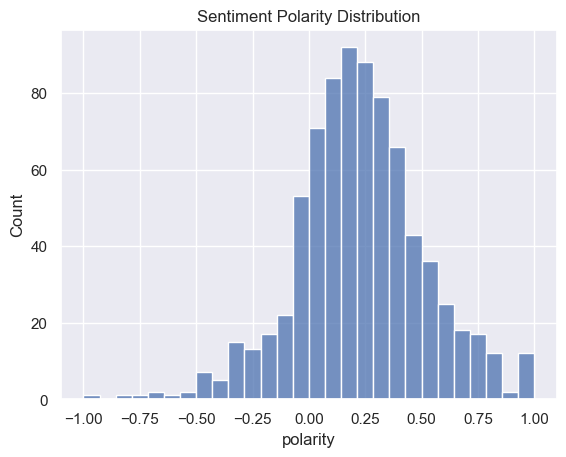

In [252]:
# distribution of polarity 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="polarity").set(title='Sentiment Polarity Distribution')
plt.show()

Sentiment analysis is a technique used to determine whether data is positive, negative or neutral. More specifically, it is essentially a natural language processing (NLP) technique that can be used to monitor the polarity of customer feedback. The TextBlob (a simple python library for NLP) library was employed in order to determine the polarity of the restaurant customer reviews. Looking at the polarity distribution obtained, it is evident that there are more positive sentiments than negative. This can be verified through the graph seen above, which displays a right skewed distribution (higher frequency of polarity values greater than zero). It should be noted that positive reviews are indicated by polarity values above zero, neutral reviews are indicated by polarity values at zero, and negative reviews are indicated by polarity values less than zero. 

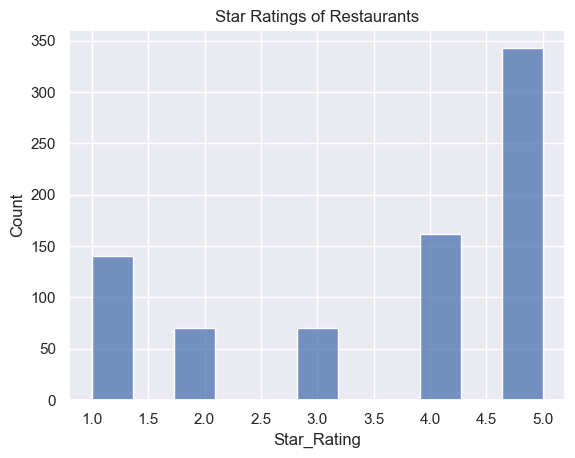

In [261]:
# distribution of star_rating 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="Star_Rating").set(title='Star Ratings of Restaurants')
plt.show()

Star ratings indicate customer satisfaction. The ratings are given on a scale of 1-5, with 1 indicating low satisfaction and 5 indicating high satisfaction. Looking at the star rating graph above, it is evident that the ratings align with the polarity score distribution seen in the previous plot. This is the case as there is a high frequency of 5 star ratings. 

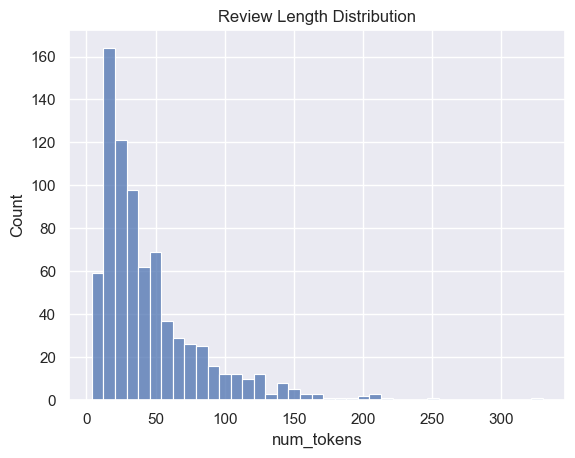

In [254]:
# distribution of review text lengths 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="num_tokens").set(title='Review Length Distribution')
plt.show()

Looking at the graph above for the length of the restaurant reviews, it is evident that the distribution is heavily right skewed. This indicates that the majority of restaurant reviews are around twenty-five words. More specifically, most of the restaurant reviews (one hundred-sixty reviews) were about twenty-five words long. The largest restaurant review is a little over two-hundred, while the smallest restaurant review is around ten words. 

Customer_Sentiment
negative    AxesSubplot(0.125,0.11;0.775x0.77)
positive    AxesSubplot(0.125,0.11;0.775x0.77)
Name: num_tokens, dtype: object

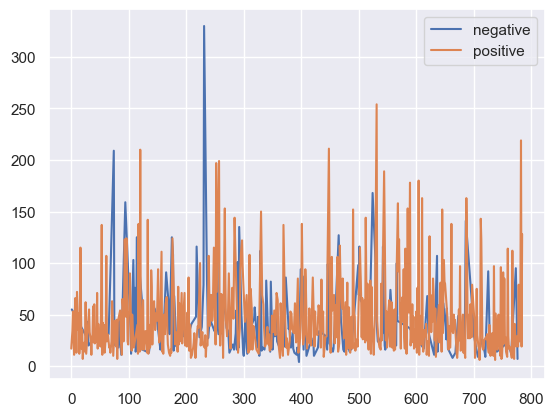

In [265]:
# distribution of review word count 
pt_df.groupby('Customer_Sentiment')['num_tokens'].plot(legend=True)

The line plot above displays the distribution of a customer's sentiments towards the restaurant in accordance with the number of words per restaurant review. The blue line indicates customers that had a negative sentiment towards the restaurant, while the orange line indicates customers that had a positive sentiment towards the restaurant. Looking at the graph, it is evident that there is no clear trend. More specifically, the type of sentiment towards a restaurant (postive or negative) does not seem to have an affect on the written length of the restaurant review.  

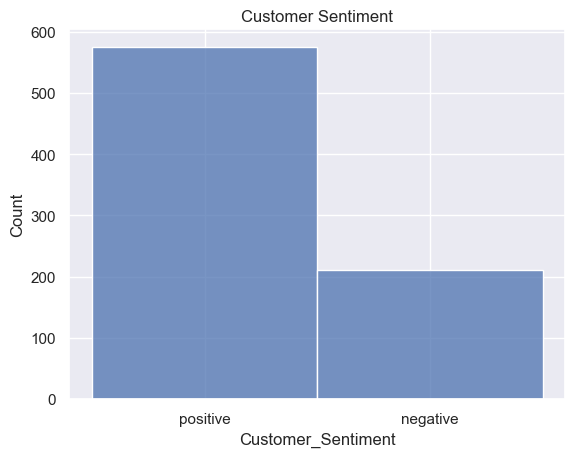

In [266]:
# distribution of positive vs negative reviews 
sns.set(style="darkgrid")
sns.histplot(data=pt_df, x="Customer_Sentiment").set(title='Customer Sentiment')
plt.show()

The customer sentiment variable indicates whether the customer feels positively or negatively towards the restaurant. In the plot above, it shows that there are more positive reviews than negative reviews. Based on this, it is evident that there is a class imbalance that should be noted. 

In [257]:
# descriptive stats for positive vs negative reviews 

# defining a fxn to pull the descriptive stats 
def f_descriptive_stats(li):
    w_l = [i for s in li for i in s]
    return descriptive_stats(w_l)

# descriptive stats for positive reviews
print("\n Descriptive Stats: Positive Reviews \n")
f_descriptive_stats(pt_df[pt_df['Customer_Sentiment']=='positive']['tokens'])

# descriptive stats for negative reviews 
print("\n Descriptive Stats: Negative Reviews \n")
f_descriptive_stats(pt_df[pt_df['Customer_Sentiment']=='negative']['tokens'])


 Descriptive Stats: Positive Reviews 

There are 26457 tokens in the data.
There are 4111 unique tokens in the data.
There are 140675 characters in the data.
The lexical diversity is 0.155 in the data.
The top 5 most common tokens
[('tacos', 813), ('food', 297), ('good', 286), ('place', 281), ('taco', 255)]

 Descriptive Stats: Negative Reviews 

There are 9503 tokens in the data.
There are 2434 unique tokens in the data.
There are 50865 characters in the data.
The lexical diversity is 0.256 in the data.
The top 5 most common tokens
[('tacos', 250), ('place', 114), ('food', 106), ('good', 99), ('get', 78)]


[9503, 2434, 0.25612964327054616, 50865]

Looking at the descriptive statistics for both the positive and negative reviews, it is evident that there are some similarities as well as differences among the reviews. First, it is evident that there are more tokens and unique tokens for positive reviews than negative reviews. Even through the positive reviews had more tokens and unique tokens, a higher lexical diversity was noted for the negative reviews. This indicates that the proportion of unique tokens to total tokens was greater for the negative reviews than the positive reviews. Another interesting thing to note is that the top five most common tokens for positive and negative restaurant reviews are fairly similar. Both have the words "tacos", "place", and "food". This makes sense as those are the key things that people look into as determining factors of positive or negative experiences. 

In [258]:
# wordcloud function obtained from Blueprints for Text Analytics Using Python textbook
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

WORDCLOUD FOR POSITIVE REVIEWS


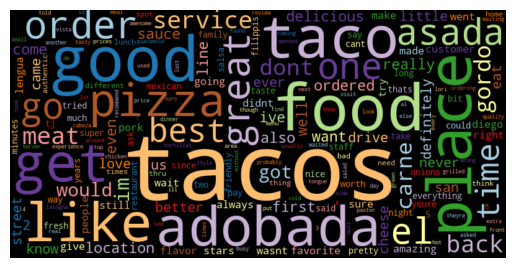

In [259]:
# positive reviews wordcloud
positive_lcount = count_words(pt_df[pt_df['Customer_Sentiment']=='positive'])
print('WORDCLOUD FOR POSITIVE REVIEWS')
wordcloud(positive_lcount.squeeze())

WORDCLOUD FOR NEGATIVE REVIEWS


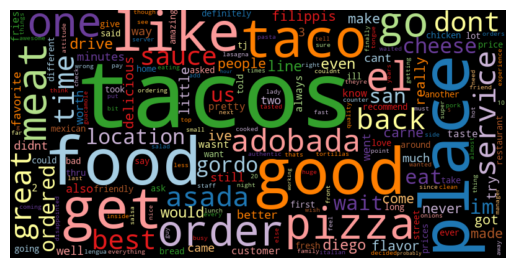

In [260]:
# negative reviews wordcloud
neg_lcount = count_words(pt_df[pt_df['Customer_Sentiment']=='negative'])
print('WORDCLOUD FOR NEGATIVE REVIEWS')
wordcloud(neg_lcount.squeeze())

The word clouds accurately reflect what was determined in the descriptive statistics for both positive and negative restaurant reviews. Looking at the wordcloud for the positive reviews, the words that stick out are "good", "pizza", "great", "best", "food", "tacos", "like", "adobada", and "place". This makes sense as these are positive words associated with the foods that are sold at the restaurants. For the negative reviews wordcloud, the words that stick out are "tacos", "order", "don’t", "food", "good", "place", and "service". This makes sense as they are words that can be used to describe people’s negative experiences. Especially the word "service", for example, is something that can be of concern for people and usually is referenced when people are not happy with how they were treated at the restaurant. Even with the word "good" showing up, it could indicate that the person is saying that it is not good. If you continue to look at the wordcloud, it is evident that there are words like "don’t", reflecting the dissatisfaction with the restaurant by the customer. 

## Part 3: Modeling & Model Evaluations

In [154]:
# final dataframe = pt_df

## References 

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python. O'Reilly.

Li, S. (2021, December 8). A Complete Exploratory Data Analysis and Visualization for Text Data. Medium. https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

Pandas Extract Number from String. (n.d.). Stack Overflow. https://stackoverflow.com/questions/37683558/pandas-extract-number-from-string